In [1]:
# Импортирую необходимые для работы библиотеки.
import pandas as pd
import numpy as np
from scipy.stats import normaltest, ttest_ind, f_oneway, ttest_rel
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Считываю файл csv
ab_test_delivery_time = pd.read_csv('experiment_lesson_4.csv')

In [3]:
# Вывод части (головы) данных
ab_test_delivery_time.head()

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control


In [4]:
# Размеры таблицы
ab_test_delivery_time.shape

(20196, 4)

In [5]:
# Кол-во пропущенных значений
ab_test_delivery_time.isna().sum()

order_id            0
delivery_time       0
district            0
experiment_group    0
dtype: int64

In [6]:
# Кол-во уникальных элементов
ab_test_delivery_time.nunique()

order_id            20196
delivery_time          72
district                3
experiment_group        2
dtype: int64

In [7]:
# Типы колонок таблицы
ab_test_delivery_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20196 entries, 0 to 20195
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          20196 non-null  int64  
 1   delivery_time     20196 non-null  float64
 2   district          20196 non-null  object 
 3   experiment_group  20196 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 631.3+ KB


In [8]:
# Описание числовых колонок
ab_test_delivery_time.describe()

,order_id,delivery_time
count,20196.000000,20196.000000
mean,11103.503565,42.054169
std,5835.424404,10.382196
min,1000.000000,10.000000
25%,6048.750000,35.000000
50%,11109.500000,42.000000
75%,16158.250000,49.000000
max,21207.000000,83.000000


In [9]:
# Описание строковых колонок
ab_test_delivery_time.describe(include='object')

,district,experiment_group
count,20196,20196
unique,3,2
top,Purlieus,test
freq,16960,10104


### Формулирование гипотезы для проверки:
1) Нулевая гипотеза (H0): Разницы между средним временем доставки в тестовой и контрольной группе нет
2) Альтернативная гипотеза (H1): Разница между средним временем доставки в тестовой и контрольной группе есть

### Строю гистограмму распределения времени доставки

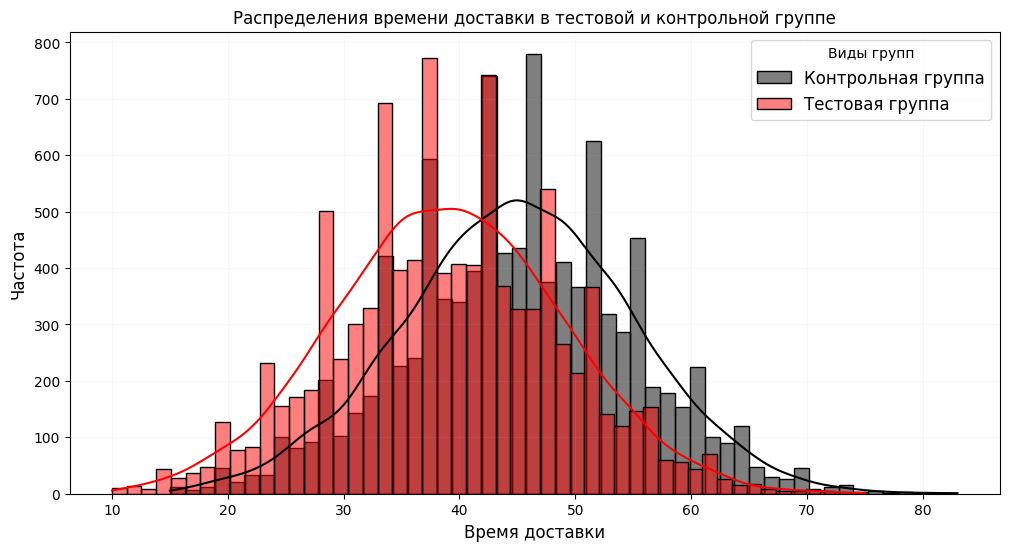

In [10]:
# Размер графика
plt.figure(figsize=(12, 6))
# Создание двух hist-плотов для контрольной и тетсовой группы на одном графике
sns.histplot(data=ab_test_delivery_time.query("experiment_group == 'control'")
             .groupby('order_id').delivery_time.sum()
             , kde=True
             , color='black'
             , label='Контрольная группа')
sns.histplot(data=ab_test_delivery_time.query("experiment_group == 'test'")
             .groupby('order_id').delivery_time.sum()
             , kde=True
             , color='red'
             , label='Тестовая группа')
# Название графика, название осей, размеры надписей.
plt.legend(title="Виды групп", fontsize=12)
plt.title("Распределения времени доставки в тестовой и контрольной группе", fontsize=12)
plt.xlabel("Время доставки", fontsize=12)
plt.ylabel("Частота", fontsize=12)
# Сетка и показ графика.
plt.grid(alpha=0.1)
plt.show()

### Нахожу количество наблюдений в тестовой и контрольной группе и вычисляю разницу по модулю

In [11]:
# Кол-во значений в группах
group_counts = ab_test_delivery_time.value_counts('experiment_group')
group_counts

experiment_group
test       10104
control    10092
Name: count, dtype: int64

In [12]:
# Нахождение в методе кол-во пользователей в группе
control_count = group_counts.get('control', 0)
test_count = group_counts.get('test', 0)

In [13]:
# Нахождение по модулю число отличия наблюдений 
quantitative_difference = abs(control_count - test_count)
print(f'Количество наблюдений в тестовой группе и контрольной отличается по модулю на {quantitative_difference}')

Количество наблюдений в тестовой группе и контрольной отличается по модулю на 12


### Проверяю выборки на нормальность с помощью теста Агостино-Пирсона (normaltest). 

Основые гипотезы:
1) Данные в контрольной группе распределены нормально 
2) Данные в тестовой группе распределены нормально

In [14]:
# Разделение данных на группы
control_group = ab_test_delivery_time[ab_test_delivery_time['experiment_group'] == 'control']['delivery_time'].dropna()
test_group = ab_test_delivery_time[ab_test_delivery_time['experiment_group'] == 'test']['delivery_time'].dropna()

In [15]:
# Использование теста Агостино-Пирсона (normaltest)
statistic_control_group, p_value_control_group = normaltest(control_group)
statistic_test_group, p_value_test_group = normaltest(test_group)

In [16]:
print(f"Статистика контрольной группы: {statistic_control_group:.2f}")
print(f"p-значение контрольной группы: {p_value_control_group:.4f}")
print(f"Статистика тестовой группы: {statistic_test_group:.2f}")
print(f"p-значение тестовой группы: {p_value_test_group:.4f}")

Статистика контрольной группы: 0.25
p-значение контрольной группы: 0.8810
Статистика тестовой группы: 7.02
p-значение тестовой группы: 0.0298


In [17]:
if p_value_control_group > 0.05:
    print("Нет достаточных оснований отвергнуть гипотезу о нормальности данных контрольной группы.")
else:
    print("Отвергаем гипотезу о нормальности данных контрольной группы.")

Нет достаточных оснований отвергнуть гипотезу о нормальности данных контрольной группы.


In [18]:
if p_value_test_group > 0.05:
    print("Нет достаточных оснований отвергнуть гипотезу о нормальности данных тестовой группы.")
else:
    print("Отвергаем гипотезу о нормальности данных тестовой группы.")

Отвергаем гипотезу о нормальности данных тестовой группы.


### Нахожу стандартное отклонение времени доставки в минутах в контрольной и тестовой группе

In [19]:
# Стандартные отклонения в контрольной и тестовой группах
std_control_group = control_group.std(ddof=1)
std_test_group = test_group.std(ddof=1)
print(f'Стандартное отклонение времени доставки в минутах в контрольной группе: {std_control_group:.2f}')
print(f'Стандартное отклонение времени доставки в минутах в тестовой группе: {std_test_group:.2f}')

Стандартное отклонение времени доставки в минутах в контрольной группе: 9.99
Стандартное отклонение времени доставки в минутах в тестовой группе: 9.88


### Сравниваю средние в тесте и контроле

In [20]:
# Вычисление процента изменения среднего времени доставки
percentage_time_change = (100 - (ab_test_delivery_time.query("experiment_group == 'test'").delivery_time.mean()/
ab_test_delivery_time.query("experiment_group == 'control'").delivery_time.mean() * 100)) * -1
print(f'На {percentage_time_change:.2f}% изменилось среднее время доставки в тестовой группе по сравнению с контрольной')

На -13.35% изменилось среднее время доставки в тестовой группе по сравнению с контрольной


### Нахождение Т-Статистики
Для данной задачи подходит двухвыборочный t-test (ttest_ind), так как необходимо сравнить средние значения контрольной и тестовой группы.

In [21]:
# Т-статистика и p-значение
t_statistic_delivery_time, p_value_delivery_time = ttest_ind(control_group, test_group)
print(f"t-статистика: {t_statistic_delivery_time:.2f}") 
print(f"р-значение: {p_value_delivery_time:.4f}")

t-статистика: 43.04
р-значение: 0.0000


### Научный вывод

In [22]:
# Вывод по нулевой гипотезе
alpha = 0.05
if p_value_delivery_time < alpha:
    print(f"""Значение p-value ({p_value_delivery_time:.4f}) ниже заданного уровня значимости ({alpha}), 
    \rзначит мы отвергаем нулевую гипотезу о равенстве среднего времени доставки
    \rу курьеров в контрольной и тестовой группах,
    \rв пользу альтернативной гипотезы о наличии статистически значимой разницы.""")
else:
    print(f"""Значение p-value ({p_value_delivery_time:.4f}) выше уровня значимости ({alpha}), 
    \rзначит у нас нет достаточных оснований для отвержения нулевой гипотезы
    \rо равенстве среднего времени доставки у курьеров в контрольной и тестовой группах.""")

Значение p-value (0.0000) ниже заданного уровня значимости (0.05), 
значит мы отвергаем нулевую гипотезу о равенстве среднего времени доставки
у курьеров в контрольной и тестовой группах,
в пользу альтернативной гипотезы о наличии статистически значимой разницы.


### Вывод понятный человеку, который не является специалистом в статистике

Расчёты показывают, что использование новой опции "по пути" действительно помогает курьерам справляться с большими объемами заказов в конце дня. 

Курьеры из тестовой группы теперь доставляют заказы быстрее, что является положительным результатом для нашей компании.